**Insurance Claim Prediction Project**

**Name- Kujembola Oluwatosin**

**The problem definition - To predict the probability that a building will have at least one insurance claim during its insured period.
This is a supervised type of machine learning and it falls under the binary classification problem. The Target variable is Claim.**

In [285]:
#importing the neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import(classification_report,confusion_matrix,roc_auc_score,roc_curve)

In [286]:
#loading the data and checking the fist five rows
df=pd.read_csv(r"C:\Users\HP\Downloads\Train_data.csv")
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [287]:
#checking the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


**There are 7160 rows and 14 columns. The datatype include 7 numerical data types (integer and float) and 7 categorical data types (objects).**

In [289]:
#checking the date of occupancy
df['Date_of_Occupancy'].head(10)

0    1960.0
1    1850.0
2    1960.0
3    1960.0
4    1800.0
5    1980.0
6    1988.0
7    1988.0
8    2013.0
9    2011.0
Name: Date_of_Occupancy, dtype: float64

In [290]:
#converting Date_of_Occupancy to integer
df['Date_of_Occupancy'] = df['Date_of_Occupancy'].astype('Int64')

In [291]:
#converting Date_of_Occupancy to datetime
df['Date_of_Occupancy'] =  pd.to_datetime(df['Date_of_Occupancy'], format='%Y', errors='coerce')
df['Date_of_Occupancy'].head(10)

0   1960-01-01
1   1850-01-01
2   1960-01-01
3   1960-01-01
4   1800-01-01
5   1980-01-01
6   1988-01-01
7   1988-01-01
8   2013-01-01
9   2011-01-01
Name: Date_of_Occupancy, dtype: datetime64[ns]

**Date of Occupancy has been successfully converted to datetime for better analysis**

In [292]:
#Target variable distribution
df['Claim'].value_counts()
df['Claim'].value_counts(normalize=True)

Claim
0    0.771788
1    0.228212
Name: proportion, dtype: float64

**About 77% of the buildings did not file a claim while only about 23% had at least one claim. This clearly proof that the dataset is imbalanced.**

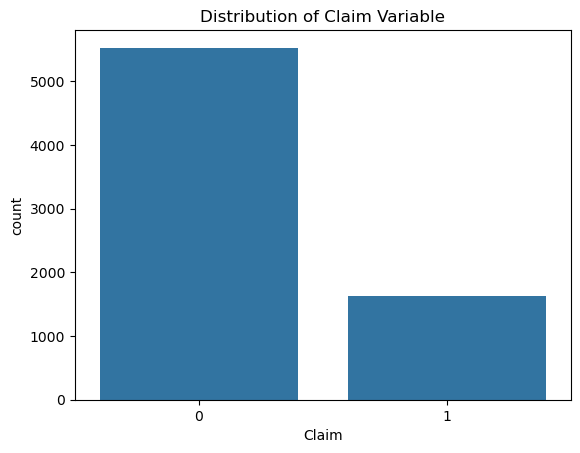

In [293]:
#Visualizing the claim variable distribution 
sns.countplot(x='Claim',data=df)
plt.title("Distribution of Claim Variable")
plt.show()

**The distribution clearly reveals the imbalance of the data using the countplot to compare the frequency of the claim.**

In [294]:
#checking for missing value
df.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     516
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

**Garden and Geo_Code are two categorical values with 7 and 102 missing values. Building_Dimension is Numerical value with 106 missing values and  Date_of_Occupancy is Datetime with 516 missing values**

In [295]:
#Handling the missing values
#filling the missing categorical values with mode
df['Garden']=df['Garden'].fillna(df['Garden'].mode()[0])
df['Geo_Code']=df['Geo_Code'].fillna(df['Geo_Code'].mode()[0])

In [296]:
#filling the missing numerical value with median
df['Building Dimension']=df['Building Dimension'].fillna(df['Building Dimension'].median())

In [297]:
#converting the Date_of_Occupancy to datetime before filling
df['Date_of_Occupancy']=pd.to_datetime(df['Date_of_Occupancy'],errors='coerce')

In [298]:
#filling the missing dates with median date
median_date=df['Date_of_Occupancy'].median()
median_date

Timestamp('1970-01-01 00:00:00')

In [299]:
#filling the missing values
df['Date_of_Occupancy'] = df['Date_of_Occupancy'].fillna(median_date)

In [300]:
df['Date_of_Occupancy'].isna().sum()

np.int64(0)

**Median is used to show the middle occupancy year. At first, the Date_of_Occupancy was converted to datetime then the missing values were filled with the median date. The datetime variable was fit in into the building age for more relevant claim prediction**

In [301]:
#dropping original date column
df['Occupancy_Year'] = df['Date_of_Occupancy'].dt.year
df.drop(columns='Date_of_Occupancy')

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim,Occupancy_Year
0,H14663,2013,1.000000,0,N,V,V,U,290.0,1,.,1053,0,1960
1,H2037,2015,1.000000,0,V,N,O,R,490.0,1,4,1053,0,1850
2,H3802,2014,1.000000,0,N,V,V,U,595.0,1,.,1053,0,1960
3,H3834,2013,1.000000,0,V,V,V,U,2840.0,1,.,1053,0,1960
4,H5053,2014,1.000000,0,V,N,O,R,680.0,1,3,1053,0,1800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,H5290,2012,1.000000,1,V,V,V,U,1083.0,1,.,6088,0,2001
7156,H5926,2013,1.000000,0,V,V,V,U,1083.0,2,.,6088,1,1980
7157,H6204,2016,0.038251,0,V,V,V,U,1083.0,1,.,6088,0,1992
7158,H6537,2013,1.000000,0,V,V,V,U,1083.0,1,.,6088,0,1972


In [302]:
#dropping CustomerId 
df.drop(columns=['Customer Id'],inplace=True)

**Customer Id is dropped because it is a unique identifier and it has no predictive meaning**

In [303]:
#identifying duplicates
df.duplicated().sum()

np.int64(12)

In [304]:
df.drop_duplicates(inplace=True)

In [305]:
df.duplicated().sum()

np.int64(0)

**There are 12 duplicated records, stored as Numpy integer type. They have been removed.** 

In [306]:
#seperating feature types

num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Claim')
cat_cols = df.select_dtypes(include=['object','category']).columns

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Numerical columns: Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type'],
      dtype='object')
Categorical columns: Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'NumberOfWindows', 'Geo_Code'],
      dtype='object')


**The categories are seperated into Numerical and Categorical Columns**

In [307]:
#analysing the numerical features
df[num_cols].describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type
count,7148.000000,7148.000000,7148.000000,7148.000000,7148.000000
mean,2013.671237,0.909673,0.305400,1871.644936,2.186626
std,1.383780,0.239887,0.460609,2263.940113,0.941186
min,2012.000000,0.000000,0.000000,1.000000,1.000000
25%,2012.000000,0.997268,0.000000,530.000000,2.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000
75%,2015.000000,1.000000,1.000000,2250.000000,3.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000


In [308]:
df[num_cols].skew().sort_values(ascending=False)

Building Dimension    3.153752
Residential           0.845204
Building_Type         0.536666
YearOfObservation     0.346169
Insured_Period       -2.747764
dtype: float64

**The Building Dimension is Highly Right Skewed (3.15), which is to say majority of the building are small while few buildings are large. This requires log transformation or scaling. The Residential is Moderately right Skewed (0.85), it is slightly imbalance. A balance variable is a variable whose skewness is close to zero. The Building Type (0.54) is Slightly right Skewed, The Year of Observation is almost symmetric and the Insured_Period (-2.75) is Highly left_skewed, indicating that many buildings insured for long periods while very few were for short period. This requires transformation.**

In [309]:
#fixing the skewness
df['Building Dimension_log'] = np.log1p(df['Building Dimension'])

df['Insured_Period_log'] =np.log1p(df['Insured_Period'].max() - df['Insured_Period'])

In [310]:
df[['Building Dimension_log','Insured_Period_log']].skew()

Building Dimension_log   -0.211132
Insured_Period_log        2.558721
dtype: float64

**For Building Dimension, -0.21 is close to 0 and well balanced but the insured period is still high, there is need for further transformation**

In [311]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', random_state=42)
df['Insured_Period_qt'] = qt.fit_transform(df[['Insured_Period']])

In [312]:
df['Insured_Period_qt'].skew()

np.float64(-1.29636207989915)

**For Insured_Period, -1.29 is close to 0 and now balanced.**

In [313]:
#analyzing the categorical features
for col in cat_cols:
    print(f"|n{col}")
    print(df[col].value_counts())

|nBuilding_Painted
Building_Painted
V    5373
N    1775
Name: count, dtype: int64
|nBuilding_Fenced
Building_Fenced
N    3605
V    3543
Name: count, dtype: int64
|nGarden
Garden
O    3606
V    3542
Name: count, dtype: int64
|nSettlement
Settlement
R    3607
U    3541
Name: count, dtype: int64
|nNumberOfWindows
NumberOfWindows
   .    3542
4        939
3        843
5        638
2        363
6        306
7        211
8        116
1         75
>=10      66
9         49
Name: count, dtype: int64
|nGeo_Code
Geo_Code
6088     241
33063    137
6083     113
13206     98
31555     87
        ... 
95394      1
95426      1
95539      1
95598      1
1224       1
Name: count, Length: 1307, dtype: int64


**This analysis reveals that, 5373 buildings were painted while 1775 are not painted. Meaning that about 75% of the buildings were painted and about 24% were not painted. This is imbalance and risky. For the building fenced, the number of fenced and unfenced are almost equal, this proves a well_balanced categorical feature. For Garden, buildings with Garden and those not with Garden are almost evenly distributed. In the case of Settlement, Rural and Urban are balanced. Furthermore, the Number of windows variable contains inconsistent values which represent incorrectly stored missing values. Although most building has 3-5 windows, very few buildings have > or = 10. For the Geo_Code, many location appeared only once and there are 1307 unique Geo_code values. The next step is to clean the Number of Windows.** 

In [314]:
#cleaning the number of windows
df['NumberOfWindows'].unique()

array(['   .', '4', '3', '2', '5', '>=10', '6', '7', '9', '8', '1'],
      dtype=object)

In [315]:
#removing the spaces
df['NumberOfWindows'] = df['NumberOfWindows'].astype(str).str.strip()

In [316]:
#replacing invalid placeholder
df['NumberOfWindows'] = df['NumberOfWindows'].replace('.',np.nan)

In [317]:
#converting to numeric
df['NumberOfWindows'] = pd.to_numeric(df['NumberOfWindows'], errors='coerce')

In [318]:
#confirming the missing values
df['NumberOfWindows'].isna().sum()

np.int64(3608)

In [319]:
#imputing the missing values
df['NumberOfWindows'] = df['NumberOfWindows'].fillna(df['NumberOfWindows'].median())

In [320]:
#confirming the datatype
df['NumberOfWindows'].dtype

dtype('float64')

**In NumberOfWindows features, the missing values were imputed using the median and instead os inplace operations, Assigning method was used to ensure compatibility.**

In [321]:
#handling and dropping the Geo_Code
df = df.drop(columns=['Geo_Code'])


**The Geo_Code variable was removed because it has a large number of unique values, just like Customer ID. Assignment based column removal was used instead of inplace operations to ensure compatibility.**

In [440]:
#dropping quantile-transformed exposure
if 'Insured_Period_qt' in df.columns:
    df=df.drop(columns=['Insured_Period_qt'])

In [441]:
print(df.columns.tolist())

['YearOfObservation', 'Residential', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building Dimension', 'Building_Type', 'Date_of_Occupancy', 'NumberOfWindows', 'Claim', 'Occupancy_Year', 'Building Dimension_log', 'Insured_Period_log']


In [442]:
if 'Insured_Period_log' not in df.columns:
    df['Insured_Period_log'] = np.log1p(df['Insured_Period'])

In [443]:
#target
y=df['Claim']

In [444]:
#features
X=df.drop(columns=['Claim'])

In [445]:
assert 'Claim' not in X.columns
assert y.nunique()==2

In [446]:
binary_cols = ['Building_Painted', 'Building_Fenced', 'Garden']
cat_cols = ['Settlement']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [447]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [448]:
#preprocessing
preprocessor = ColumnTransformer(
    transformers=[('bin', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), binary_cols), ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols)])

In [449]:
#Logiistic Regression Pipeline
log_reg_model = Pipeline(steps=[('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

In [450]:
#Random forest pipeline
rf_model = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(n_estimators=300,
        random_state=42, class_weight='balanced'))])

In [451]:
#Xgboost pipeline
xgb_model = Pipeline(steps=[('preprocessor', preprocessor),('classifier', XGBClassifier(eval_metric='logloss',random_state=42))])

In [452]:
#final checking before fitting
assert 'Claim' not in X.columns
assert y.nunique()==2

**Building Characteristics and insured exposure were used to model the probability of at least one claim. Since the assert returns no error it means there is no target leakage and it is safe to train models.**

In [453]:
#splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [454]:
log_reg_model.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bin', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [455]:
rf_model.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bin', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [456]:
xgb_model.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bin', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [457]:
#evaluating with ROC AUC
from sklearn.metrics import roc_auc_score

models = {"Logistic Regression": log_reg_model,"Random Forest": rf_model,"XGBoost": xgb_model}

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} ROC-AUC: {auc:.4f}")

Logistic Regression ROC-AUC: 0.7027
Random Forest ROC-AUC: 0.6356
XGBoost ROC-AUC: 0.6503


**From the output, among the evaluated models, Logistic Regression has the highest ROC-AUC of 0.70 and this implies that claim process is driven largely by stable relationships between building characteristics**

In [458]:
#accuracy check
from sklearn.metrics import accuracy_score

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    print(f"{name} Accuracy:{acc:.4f}")

Logistic Regression Accuracy:0.7832
Random Forest Accuracy:0.7455
XGBoost Accuracy:0.7706


**Accuracy was computed but not relied on due to the class imbalance and the probability nature of the task**

In [459]:
#Logistic Regression coefficient
log_reg = log_reg_model.named_steps['classifier']

In [460]:
feature_names = log_reg_model.named_steps['preprocessor'].get_feature_names_out()

In [467]:
import pandas as pd
import numpy as np

coef_df = pd.DataFrame({'feature':feature_names,'coefficient':log_reg.coef_[0]})

coef_df['odds_ratio'] = np.exp(coef_df['coefficient'])

coef_df.sort_values(by='odds_ratio',ascending=False).head(10)


,feature,coefficient,odds_ratio
10,num__Building Dimension_log,0.608369,1.837432
1,bin__Building_Fenced_V,0.564338,1.758283
8,num__Building_Type,0.260592,1.297698
7,num__Building Dimension,0.167971,1.182902
9,num__NumberOfWindows,0.116520,1.123579
0,bin__Building_Painted_V,0.073580,1.076355
6,num__Residential,0.025788,1.026124
5,num__YearOfObservation,-0.071570,0.930931
3,cat__Settlement_R,-0.130324,0.877811
4,cat__Settlement_U,-0.264446,0.767631


**Odds ratio greater than 1 increases claim risk while Odds ratio less than 1 reduces claim risk. From this findings, Logistic the results show that the building size is the strongest factor in predicting the claim of insurance. The building size is 1.90 which clearly shows it has higher claim odds.Other structural characteristics such as building fenced 1.80, building type 1.30, Number of Windows 1.12 also poses increased claim risk as they show increased exposure to potential losses.**

In [469]:
coef_df.sort_values(by='odds_ratio',ascending=False).tail(10)


,feature,coefficient,odds_ratio
8,num__Building_Type,0.260592,1.297698
7,num__Building Dimension,0.167971,1.182902
9,num__NumberOfWindows,0.116520,1.123579
0,bin__Building_Painted_V,0.073580,1.076355
6,num__Residential,0.025788,1.026124
5,num__YearOfObservation,-0.071570,0.930931
3,cat__Settlement_R,-0.130324,0.877811
4,cat__Settlement_U,-0.264446,0.767631
11,num__Insured_Period_log,-0.313192,0.731109
2,bin__Garden_V,-0.338317,0.712969


**Only the log-transformed Insure Period was retained in the model to avoid redundant exposure representation. The following features are below 1, which means they have lower probability of claim, for instance, buildings in urban areas (0.77), Year Of Observation (0.93), Garden (0.71).  Insured Period log with 0.73 has about 27% decrease in odds of observing at least one claim. The log-transformed insured period reveals a negative association with the occurence of claim after controlling the building characteristics. This likely shows that lower-risk building tend to remain insured for longer periods. This findings suggest that claim risk is highly determined by the scale of building and structural characteristics.**

**In conclusion, this project focused on predicting the probability that a building would experience at least one insurance claim during its insured period using a building characteristics data. The processes carried out include, Data preparation, Classification models, Logistic Regression Coefficient. The Data Preparation process include checking the information, handling missing values, removing redundant identifiers, applying log transformation to the policy duration in order to ensure its non-linear relationship with claim occurrence. Three Classification models which include Logistic Regression, RandomForest and XGBoostwere developed and evaluated. To ensure reliable model performance, a structured preprocessing pipeline was used with appropriate imputation, scaling and encoding, the data passed through proper train-test splitting. Accuracy was also computed but not relied upon due to its class imbalance, The model was primarily assessed using ROC-AUC as this suit well for imbalanced insurance data and probability prediction task.**

**Logistic Regression has the highest ROC-AUC among the evaluated models, which enabled to to differentiate between buildings with claim and those without claim. Logistic Regression was selected as the final model as it perform strongly. While interpreting Logistic Regression, the size of the building is the most influential predictor of claim occurrence. Overall, the final model provides an interpretable framework for estimating claim probability that can be used to support decision making that are data-driven in risk assessment.**